In [1]:
import rasterio
import numpy as np
import os

import torch
from torch import nn

from torchgeo.models import resnet18

import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from rasterio.windows import Window


In [2]:
# Define Sentinel-2 band resolutions
sentinel2_band_resolutions = {
    "R10m": ["B02", "B03", "B04", "B08"], #10m resolution bands
    "R20m": ["B05", "B06", "B07", "B8A", "B11", "B12"], #20m resolution bands
    "R60m": ["AOT", "SCL", "WVP"] #60m resolution bands
}

base_folder = "IMG_DATA" #base folder containing Sentinel-2 data

# Function to list available Sentinel-2 data
def list_sentinel2_files(base_folder, resolutions, band_names):
    sentinel2_files = {}
    for res, bands in band_names.items():
        resolution_folder = os.path.join(base_folder, res)
        if not os.path.exists(resolution_folder):
            print(f"Warning: Resolution folder {resolution_folder} does not exist!")
            continue
        for file in os.listdir(resolution_folder):
            for band in bands:
                if band in file:
                    sentinel2_files.setdefault(res, []).append(os.path.join(resolution_folder, file))
    return sentinel2_files

# Load bands and collect metadata
def load_bands(file_dict):
    bands = []
    metadata_list = []
    for res, files in file_dict.items():
        for file_path in files:
            try:
                with rasterio.open(file_path) as src:
                    band_data = src.read(1)  #read the first (and only) band
                    bands.append(band_data)
                    metadata_list.append({
                        "file": file_path,
                        "transform": src.transform,
                        "crs": src.crs,
                        "height": src.height,
                        "width": src.width,
                        "dtype": band_data.dtype
                    })
            except rasterio.errors.RasterioIOError as e:
                print(f"Error reading {file_path}: {e}")
    return bands, metadata_list

# Save all bands as a multi-layer geoTIFF
def save_as_multiband_geotiff(output_path, bands, metadata_list):
    if not bands:
        print("No bands available to save.")
        return

    # Use the metadata of the first band for the geoTIFF structure
    meta = metadata_list[0].copy()
    meta.update({
        "count": len(bands), #number of bands
        "driver": "GTiff",
        "dtype": "uint16", #match Sentinel2 raw data type
    })

    with rasterio.open(output_path, "w", **meta) as dst:
        for i, band in enumerate(bands):
            #Ensure band shape matches the expected dimensions
            if band.shape != (meta["height"], meta["width"]):
                print(f"Skipping band {i+1}: shape {band.shape} does not match ({meta['height']}, {meta['width']})")
                continue
            dst.write(band, i + 1)  #write each band as a separate layer

if not os.path.exists("sentinel2_allBands.tif"): #check if output_file already exists to reduce the processing time
    # Discover Sentinel-2 files in the base folder
    sentinel2_files = list_sentinel2_files(base_folder, sentinel2_band_resolutions, sentinel2_band_resolutions)
    
    # Load bands and metadata
    bands, metadata_list = load_bands(sentinel2_files)
    
    # Print a summary of loaded bands
    print(f"Loaded {len(bands)} bands.")
    for metadata in metadata_list:
        print(f"File: {metadata['file']}, Size: {metadata['height']}x{metadata['width']}, CRS: {metadata['crs']}")
    
    # Save the loaded bands as a multi-layer geoTIFF
    output_file = "sentinel2_allBands.tif"
    save_as_multiband_geotiff(output_file, bands, metadata_list)
    print(f"Saved Sentinel-2 multi-layer image as {output_file}")
else:
    output_file = "sentinel2_allBands.tif"
    print(f"File {output_file} already exists. Skipping band merging step.")


File sentinel2_allBands.tif already exists. Skipping band merging step.


In [3]:
# Load ResNet18 model
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  #10 classes for EuroSAT, load full model
model_root = "torchgeo_data/models/torchgeo_resnet.pth"
model.load_state_dict(torch.load(model_root))
model.eval()


ResNet(
  (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, 

In [4]:
# Open the geoTIFF file and read all bands
with rasterio.open(output_file) as src:
    sentinel2_img = src.read()  #read all bands as a numpy array (shape: [bands, height, width])

# Extract a subset from the center of the image
h, w = sentinel2_img.shape[1], sentinel2_img.shape[2]
subset_size = 2000
center_x, center_y = w // 2, h // 2
half_size = subset_size // 2

# Subset the image
subset_img = sentinel2_img[:, center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size] #shape: (bands, subset_size, subset_size)

# Update dimensions for the subset
output_classes = np.zeros((subset_size, subset_size), dtype=np.uint8) #initialize classification output for the subset

# Update dimensions for the subset
h, w = subset_img.shape[1], subset_img.shape[2]
output_classes = np.zeros((h, w), dtype=np.uint8) #initialize classification output for the subset


In [5]:
# sliding window classification parameters
patch_size = 10
stride = 10

# Calculate the total steps for progress tracking based on the subset
total_steps = (h // patch_size) * (w // patch_size)
step_count = 0
start_time = time.time()  #reset timer

# loops over the subset image with a sliding window approach
for i in range(0, h - patch_size + 1, stride):
    for j in range(0, w - patch_size + 1, stride):
        # Extract patch
        patch = subset_img[:, i:i+patch_size, j:j+patch_size] #extract (patch size)x(patch size) patches
        patch = patch.astype(np.float32)  #convert the patch to img format- suitable for the model
        input_tensor = torch.from_numpy(patch).unsqueeze(0) #transform the img into a tensor
        input_tensor = (input_tensor - 0.5) / 0.5  #match training normalization

        with torch.no_grad():
            output = model(input_tensor) #to get the output predictions
            _, predicted = torch.max(output, 1) #the highest predicted probability

        #assign the classification result to the corresponding patch area
        output_classes[i:i+patch_size, j:j+patch_size] = predicted.item()
            
        # timing - update and print progress
        step_count += 1
        if step_count % 100 == 0 or step_count == total_steps: #print every 100 steps or at the end
            elapsed_time = time.time() - start_time
            
            remaining_steps = total_steps - step_count
            time_per_step = elapsed_time / step_count
            remaining_time = remaining_steps * time_per_step
            
            print(f"Progress: {step_count}/{total_steps} - Elapsed: {elapsed_time:.2f}s - Remaining: {remaining_time:.2f}s", end="\r")

print("")
# Calculating class percentages
class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]
#calculate unique classes and the number of each
unique_classes, class_counts = np.unique(output_classes, return_counts=True)
#take total pixel number
total_pixels = output_classes.size
class_percentages = {cls: 0.0 for cls in range(len(class_names))}
#calculate percantage of each classes
percentages = (class_counts / total_pixels) * 100 #create a dictionary to hold percentages for all classes
#fill in the percentages for the classes that exist
for cls, count in zip(unique_classes, class_counts):
    class_percentages[cls] = (count / total_pixels) * 100
#print the results, including classes with 0%
for cls, pct in class_percentages.items():
    class_name = class_names[cls] #reach the class name
    print(f"Class {cls} ({class_name}): {pct:.2f}%")



Progress: 40000/40000 - Elapsed: 144.53s - Remaining: 0.00ss
Class 0 (AnnualCrop): 7.95%
Class 1 (Forest): 0.38%
Class 2 (HerbaceousVegetation): 39.65%
Class 3 (Highway): 4.14%
Class 4 (Industrial): 0.72%
Class 5 (Pasture): 0.01%
Class 6 (PermanentCrop): 0.55%
Class 7 (Residential): 0.00%
Class 8 (River): 0.02%
Class 9 (SeaLake): 46.60%


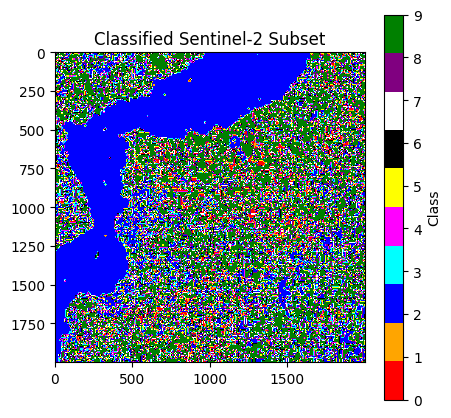

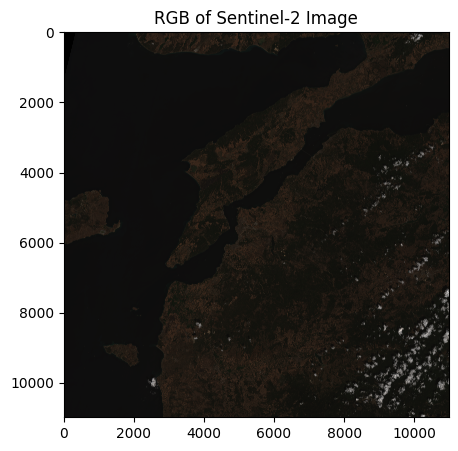

In [6]:
# Visualization of the classified image
colors = ['red', 'orange', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'purple', 'green']
cmap = ListedColormap(colors)

#plot it
plt.figure(figsize=(5, 5))
plt.imshow(output_classes, cmap=cmap, vmin=0, vmax=9)
plt.colorbar(ticks=range(10), label="Class")
plt.title("Classified Sentinel-2 Subset")
plt.show()

# Visualization of the subset image
red_idx = 3 #B04
green_idx = 2 #B03
blue_idx = 1 #B02

#open the geoTIFF file with rasterio
with rasterio.open(output_file) as src:
    #read the RGB bands and convert them for rasterio
    red = src.read(red_idx).astype(np.float32)
    green = src.read(green_idx).astype(np.float32)
    blue = src.read(blue_idx).astype(np.float32)
    
#normalize the band values to [0, 1] for plotting
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

#stack the bands into an RGB image
rgb_image = np.stack((red_norm, green_norm, blue_norm), axis=-1)

#plot it
plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)
plt.title("RGB of Sentinel-2 Image")
plt.show()


In [7]:
# Get the geoinformation from the sentinel2 data
with rasterio.open("sentinel2_allBands.tif") as src:
    transform = src.transform
    crs = src.crs

# Adjust the transform to match the subset area
subset_transform = rasterio.windows.transform(
    rasterio.windows.Window(center_x - half_size, center_y - half_size, subset_size, subset_size),
    transform
)

# Save the classified subset as a geoTIFF
classified_file = "IMG_DATA/classified_subset_sentinel2.tif"
with rasterio.open(
    classified_file,
    "w",
    driver="GTiff",
    height=output_classes.shape[0],
    width=output_classes.shape[1],
    count=1,  #single band for classification
    dtype=np.uint8,
    crs=crs,
    transform=subset_transform,
) as dst:
    dst.write(output_classes, 1) #write the classification layer

    #add metadata too, to keep the number of classes info (10) even if there is a class with 0%
    dst.update_tags(
        CLASS_NAMES=",".join(class_names) #add class names to the metadata
    )
    
print(f"Classified subset saved as {classified_file}")


Classified subset saved as IMG_DATA/classified_subset_sentinel2.tif
